<a href="https://colab.research.google.com/github/yuvalpn/traffic_violation2012_2017/blob/main/traffic_violation_montana2012_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Imports & Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Visualization settings
%matplotlib inline
sns.set_theme(style="whitegrid", palette="pastel")

# Mount Drive
drive.mount('/content/drive')

# Load Data (Update path to your specific folder)
file_path = '/content/drive/My Drive/my_data/traffic_violations.csv'

# Reading the file (Optimized for large files if needed)
try:
    df = pd.read_csv(file_path, low_memory=False) # low_memory=False helps with mixed types warnings
    print("✅ File loaded successfully!")
except FileNotFoundError:
    print("❌ File not found. Please check the path.")

Mounted at /content/drive
✅ File loaded successfully!


In [2]:
def clean_data(raw_df):
    # Create a copy to avoid SettingWithCopyWarning
    df = raw_df.copy()

    # Drop duplicates
    df = df.drop_duplicates()

    # Convert Date & Time (Optimized)
    # Using errors='coerce' turns bad data into NaT (Not a Time)
    df['date_of_stop'] = pd.to_datetime(df['date_of_stop'], format='%m/%d/%Y', errors='coerce')

    # Extract time components efficiently
    df['stop_year'] = df['date_of_stop'].dt.year
    df['stop_month'] = df['date_of_stop'].dt.month
    df['day_of_week'] = df['date_of_stop'].dt.day_name()
    df['hour'] = pd.to_datetime(df['time_of_stop'], format='%H:%M:%S', errors='coerce').dt.hour

    # Clean Subagency column
    # Check if column is string before using .str accessor
    if df['subagency'].dtype == 'O':
         df['subagency_code'] = df['subagency'].str.extract(r', (.{5})')[0]
    else:
         df['subagency_code'] = df['subagency']

    return df

# Apply cleaning
df_clean = clean_data(df)
print("✅ Data cleaned and ready for analysis.")

✅ Data cleaned and ready for analysis.


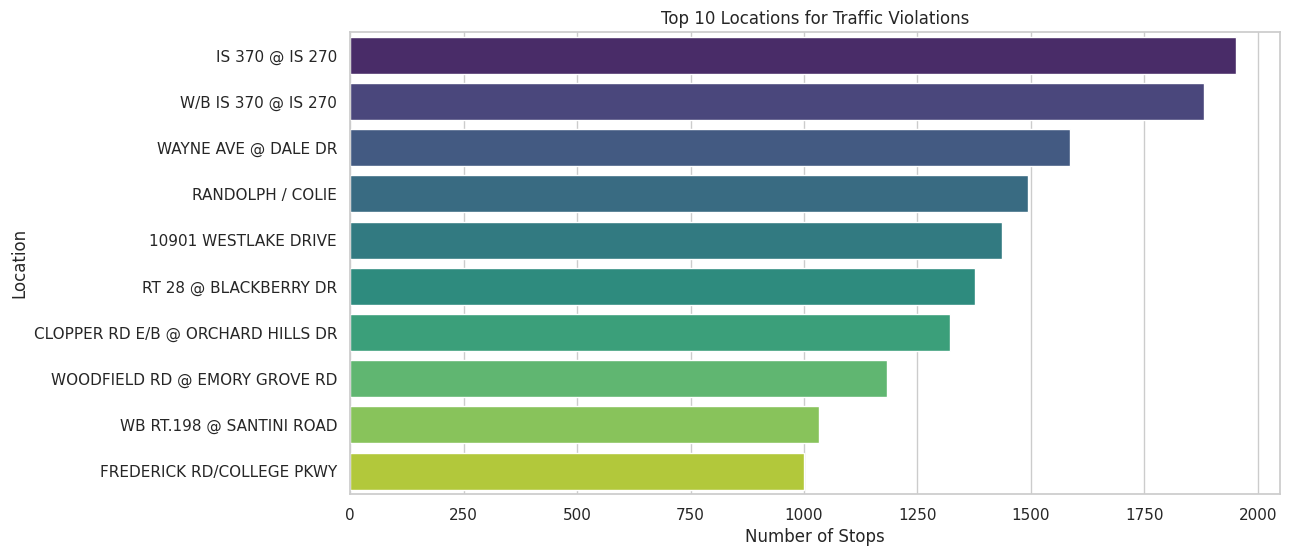

In [3]:
# Analysis: Top 10 Locations for Traffic Stops
top_locations = df_clean['location'].value_counts().head(10).reset_index()
top_locations.columns = ['location', 'count']

plt.figure(figsize=(12, 6))
# Swapped x and y for better readability
sns.barplot(data=top_locations, x='count', y='location', hue='location', palette='viridis', legend=False)
plt.title('Top 10 Locations for Traffic Violations')
plt.xlabel('Number of Stops')
plt.ylabel('Location')
plt.show()

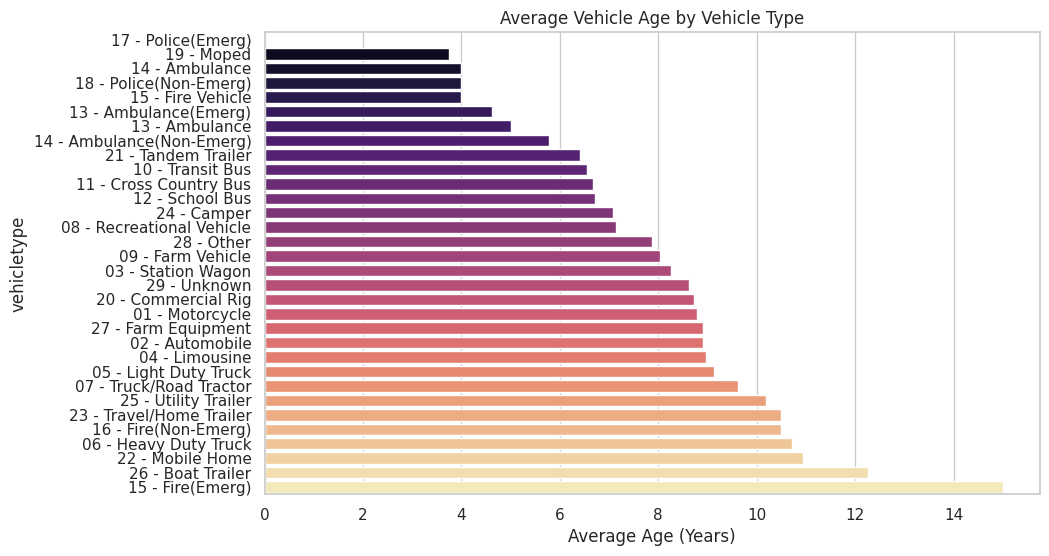

In [4]:
# Calculate Vehicle Age
# Filter out bad data (e.g., year 0 or future years)
current_year = pd.Timestamp.now().year
valid_cars = df_clean[(df_clean['year'] > 1980) & (df_clean['year'] <= current_year)].copy()

valid_cars['vehicle_age'] = valid_cars['stop_year'] - valid_cars['year']

# Visualizing Average Vehicle Age by Violation Type (or Vehicle Type)
avg_age = valid_cars.groupby('vehicletype')['vehicle_age'].mean().sort_values().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_age, x='vehicle_age', y='vehicletype', hue='vehicletype', palette='magma', legend=False)
plt.title('Average Vehicle Age by Vehicle Type')
plt.xlabel('Average Age (Years)')
plt.show()

⚠️ Note: Common colors (Silver, Black) have more accidents simply because there are more of them on the road.


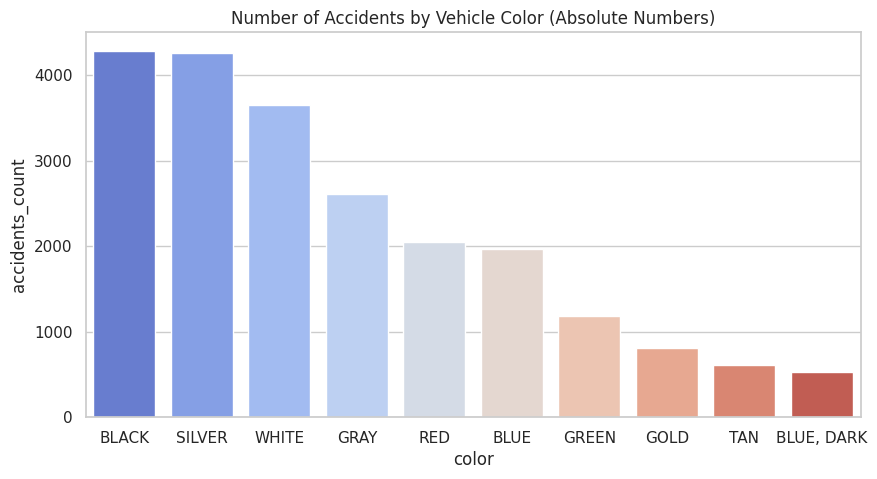

In [5]:
# Analysis: Accidents by Color
# Filter only rows where an accident occurred
accidents = df_clean[df_clean['contributed_to_accident'] == True]

# Count top colors
accident_colors = accidents['color'].value_counts().head(10).reset_index()
accident_colors.columns = ['color', 'accidents_count']

print("⚠️ Note: Common colors (Silver, Black) have more accidents simply because there are more of them on the road.")

plt.figure(figsize=(10, 5))
sns.barplot(data=accident_colors, x='color', y='accidents_count', hue='color', palette='coolwarm', legend=False)
plt.title('Number of Accidents by Vehicle Color (Absolute Numbers)')
plt.show()

Sanity Check - Sample Parsed Times:
0   1900-01-01 17:11:00
1   1900-01-01 00:41:00
2   1900-01-01 23:12:00
3   1900-01-01 16:10:00
4   1900-01-01 12:52:00
Name: time_of_stop, dtype: datetime64[ns]
------------------------------

=== Contingency Table (Observed Counts) ===
alcohol               False  True 
time_period                       
Day (06:00-21:00)    702902   1676
Night (22:00-05:00)  343677    320
------------------------------

=== Chi-Square Test Results ===
P-value: 2.7171410087393427e-57
Conclusion: The result is Statistically Significant.
There is a strong dependency between the time of day and alcohol violations.


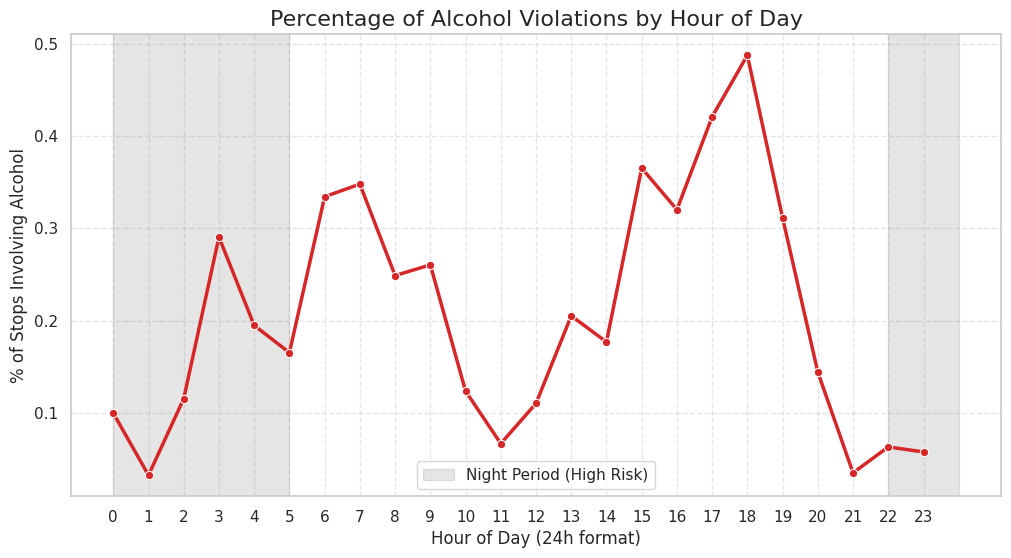

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 1. Load Data
# We are loading only necessary columns to optimize performance
file_path = '/content/drive/My Drive/my_data/traffic_violations.csv'
df = pd.read_csv(file_path, usecols=['time_of_stop', 'alcohol', 'violation_type'])

# ---------------------------------------------------------
# 2. Data Cleaning & Time Parsing (THE FIX)
# ---------------------------------------------------------

# The previous code failed here because it used '%H' (24-hour clock).
# We are now using '%I' (12-hour clock) and '%p' (AM/PM indicator) to correctly parse the input.
# errors='coerce' will turn unreadable rows into NaT (Not a Time) instead of crashing.
df['time_of_stop'] = pd.to_datetime(df['time_of_stop'], format='%I:%M:%S %p', errors='coerce')

# Verify that the conversion worked by printing sample non-null values
print("Sanity Check - Sample Parsed Times:")
print(df['time_of_stop'].dropna().head())
print("-" * 30)

# Extract the hour (0-23) from the datetime object
df['hour'] = df['time_of_stop'].dt.hour

# Handle missing values in 'alcohol': assume False (No Alcohol) if the field is empty
df['alcohol'] = df['alcohol'].fillna(False).astype(bool)

# ---------------------------------------------------------
# 3. Feature Engineering: Day vs. Night
# ---------------------------------------------------------

def classify_time(hour):
    """
    Classifies the time of stop into 'Day' or 'Night'.
    Night is defined as 22:00 (10 PM) to 05:00 (5 AM) based on typical DUI patterns.
    """
    # Handle cases where hour parsing failed
    if pd.isna(hour):
        return 'Unknown'

    if 22 <= hour or hour <= 5:
        return 'Night (22:00-05:00)'
    else:
        return 'Day (06:00-21:00)'

# Apply the classification logic
df['time_period'] = df['hour'].apply(classify_time)

# Remove rows where time could not be determined to ensure statistical accuracy
df_clean = df[df['time_period'] != 'Unknown'].copy()

# ---------------------------------------------------------
# 4. Statistical Analysis (Chi-Square Test)
# ---------------------------------------------------------

# Create a contingency table: Time Period vs. Alcohol Involvement
contingency_table = pd.crosstab(df_clean['time_period'], df_clean['alcohol'])

print("\n=== Contingency Table (Observed Counts) ===")
print(contingency_table)
print("-" * 30)

# Run Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\n=== Chi-Square Test Results ===")
print(f"P-value: {p}")

# Interpret the results for the report
if p < 0.05:
    print("Conclusion: The result is Statistically Significant.")
    print("There is a strong dependency between the time of day and alcohol violations.")
else:
    print("Conclusion: No significant relationship found (Null Hypothesis accepted).")

# ---------------------------------------------------------
# 5. Visualization
# ---------------------------------------------------------

# Calculate the percentage of alcohol violations per hour (Normalization)
# This accounts for the fact that there is less traffic volume at night.
hourly_stats = df_clean.groupby('hour')['alcohol'].mean() * 100

plt.figure(figsize=(12, 6))

# Plot the trend line
sns.lineplot(x=hourly_stats.index, y=hourly_stats.values, marker='o', color='#d62728', linewidth=2.5)

# Add context: Highlight the "Night" hours
plt.axvspan(22, 24, color='gray', alpha=0.2, label='Night Period (High Risk)')
plt.axvspan(0, 5, color='gray', alpha=0.2)

# Styling the chart
plt.title('Percentage of Alcohol Violations by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (24h format)', fontsize=12)
plt.ylabel('% of Stops Involving Alcohol', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.show()

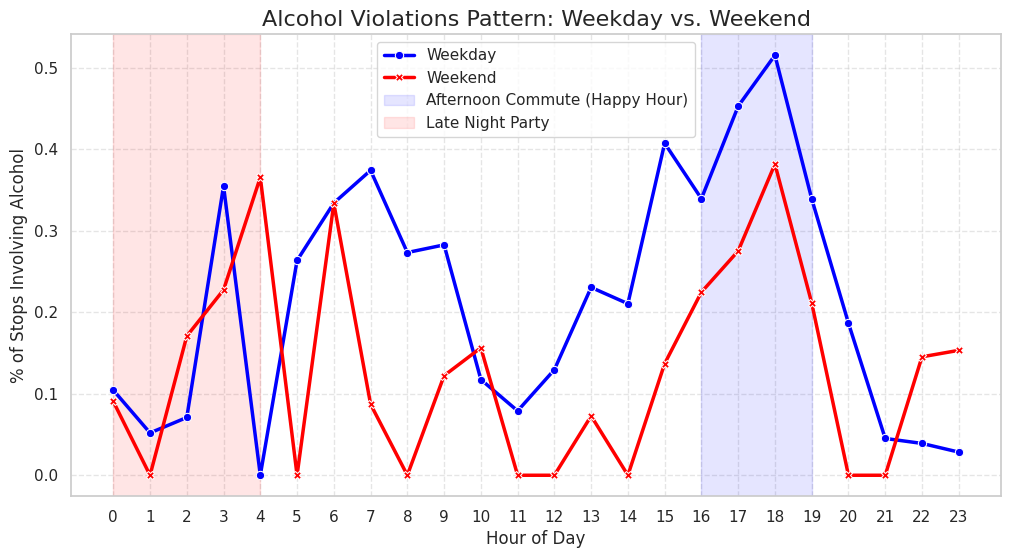

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data (Adding 'date_of_stop' to identify days)
file_path = '/content/drive/My Drive/my_data/traffic_violations.csv'
df = pd.read_csv(file_path, usecols=['date_of_stop', 'time_of_stop', 'alcohol'])

# ---------------------------------------------------------
# 2. Data Parsing
# ---------------------------------------------------------

# Parse Time
df['time_of_stop'] = pd.to_datetime(df['time_of_stop'], format='%I:%M:%S %p', errors='coerce')
df['hour'] = df['time_of_stop'].dt.hour

# Parse Date
df['date_of_stop'] = pd.to_datetime(df['date_of_stop'], format='%m/%d/%Y', errors='coerce')
df['day_name'] = df['date_of_stop'].dt.day_name()

# Handle Alcohol (NaN = False)
df['alcohol'] = df['alcohol'].fillna(False).astype(bool)

# ---------------------------------------------------------
# 3. Define Weekend vs. Weekday
# ---------------------------------------------------------

def get_day_type(day):
    if day in ['Saturday', 'Sunday']:
        return 'Weekend'
    else:
        return 'Weekday'

df['day_type'] = df['day_name'].apply(get_day_type)

# ---------------------------------------------------------
# 4. Aggregation & Visualization
# ---------------------------------------------------------

# Calculate percentage of alcohol stops per hour, split by Day Type
hourly_stats = df.groupby(['hour', 'day_type'])['alcohol'].mean() * 100
hourly_stats = hourly_stats.reset_index()

# Plotting
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=hourly_stats,
    x='hour',
    y='alcohol',
    hue='day_type',       # Split lines by Weekend/Weekday
    style='day_type',     # Different line styles
    markers=True,
    dashes=False,
    palette={'Weekend': 'red', 'Weekday': 'blue'},
    linewidth=2.5
)

# Styling
plt.title('Alcohol Violations Pattern: Weekday vs. Weekend', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('% of Stops Involving Alcohol', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)

# Add context highlights
plt.axvspan(16, 19, color='blue', alpha=0.1, label='Afternoon Commute (Happy Hour)')
plt.axvspan(0, 4, color='red', alpha=0.1, label='Late Night Party')

plt.legend()
plt.show()

=== Outcome Probability by Gender (%) ===
violation_type   Citation     ESERO    Warning
gender                                        
F               43.844431  4.705174  51.450395
M               51.255339  5.170997  43.573664
U               11.515152  0.606061  87.878788
------------------------------


<Figure size 800x500 with 0 Axes>

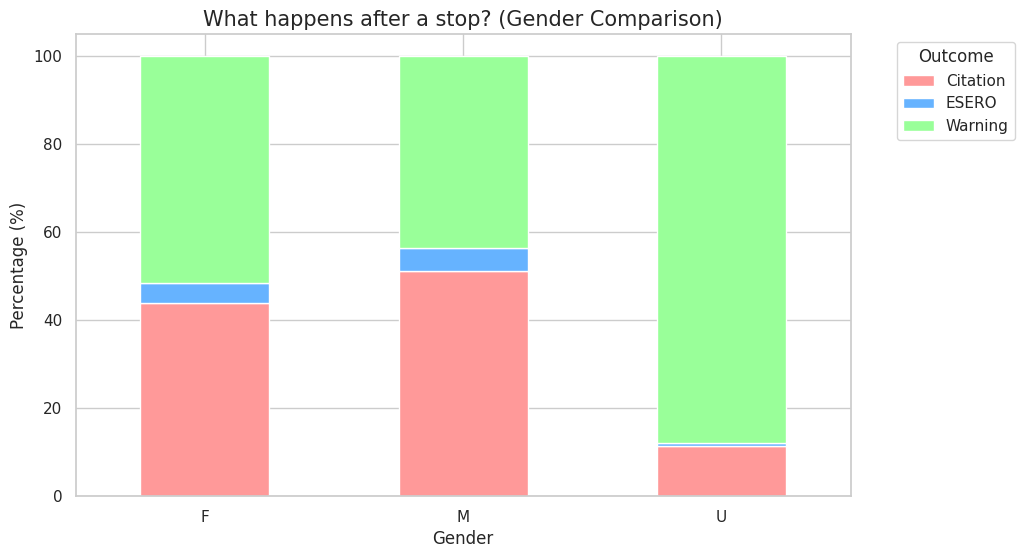

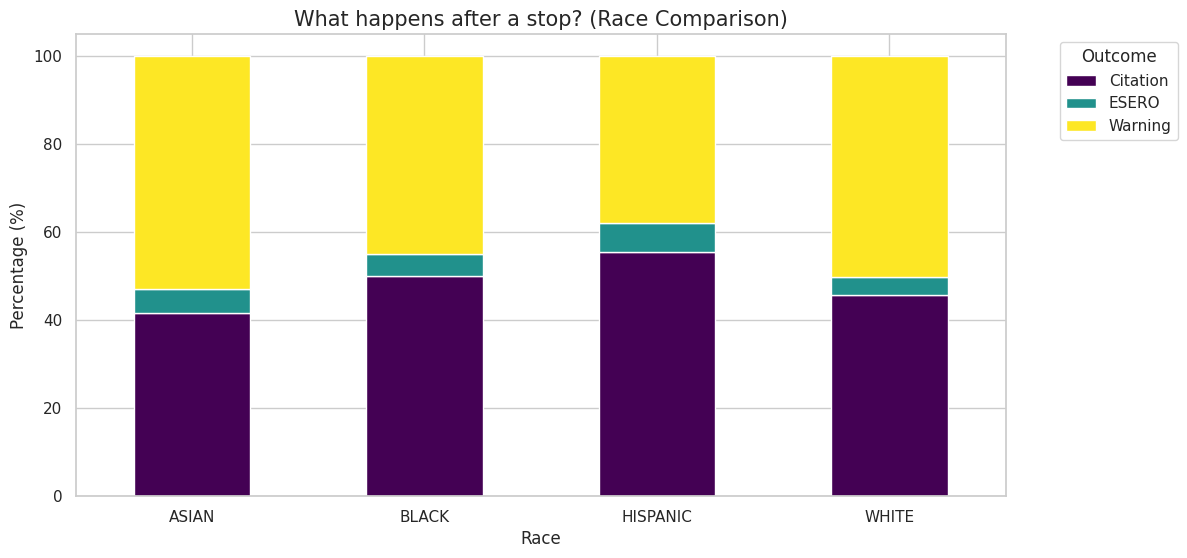

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
file_path = '/content/drive/My Drive/my_data/traffic_violations.csv'
# We need Gender, Race, and the Outcome (violation_type)
df = pd.read_csv(file_path, usecols=['gender', 'race', 'violation_type'])

# 2. Data Cleaning
# Remove missing values to ensure accuracy
df = df.dropna()

# Filter for the most common violation types to reduce noise (usually Citation, Warning, ESERO)
common_violations = ['Citation', 'Warning', 'ESERO'] # ESERO = Equipment Repair Order
df = df[df['violation_type'].isin(common_violations)]

# ---------------------------------------------------------
# Analysis A: The "Gender Gap" (Battle of the Sexes)
# ---------------------------------------------------------

# Calculate the percentage of each outcome per Gender
# normalize=True turns counts into percentages (0.5 = 50%)
gender_outcome = df.groupby('gender')['violation_type'].value_counts(normalize=True).unstack() * 100

print("=== Outcome Probability by Gender (%) ===")
print(gender_outcome)
print("-" * 30)

# Visualization: Gender Outcome
plt.figure(figsize=(8, 5))
# Plotting a stacked bar chart to show the composition of outcomes
gender_outcome.plot(kind='bar', stacked=True, color=['#ff9999','#66b3ff','#99ff99'], figsize=(10,6))

plt.title('What happens after a stop? (Gender Comparison)', fontsize=15)
plt.ylabel('Percentage (%)')
plt.xlabel('Gender')
plt.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

# ---------------------------------------------------------
# Analysis B: Race Disparities
# ---------------------------------------------------------

# Keep only top 4 races to keep the chart readable
top_races = df['race'].value_counts().head(4).index
df_race = df[df['race'].isin(top_races)]

# Calculate percentages
race_outcome = df_race.groupby('race')['violation_type'].value_counts(normalize=True).unstack() * 100

# Visualization: Race Outcome
race_outcome.plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')

plt.title('What happens after a stop? (Race Comparison)', fontsize=15)
plt.ylabel('Percentage (%)')
plt.xlabel('Race')
plt.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

=== Traffic Stops per Year ===
   year   count
0  2012  151365
1  2013  190519
2  2014  223721
3  2015  235349
4  2016  219624
5  2017   27997


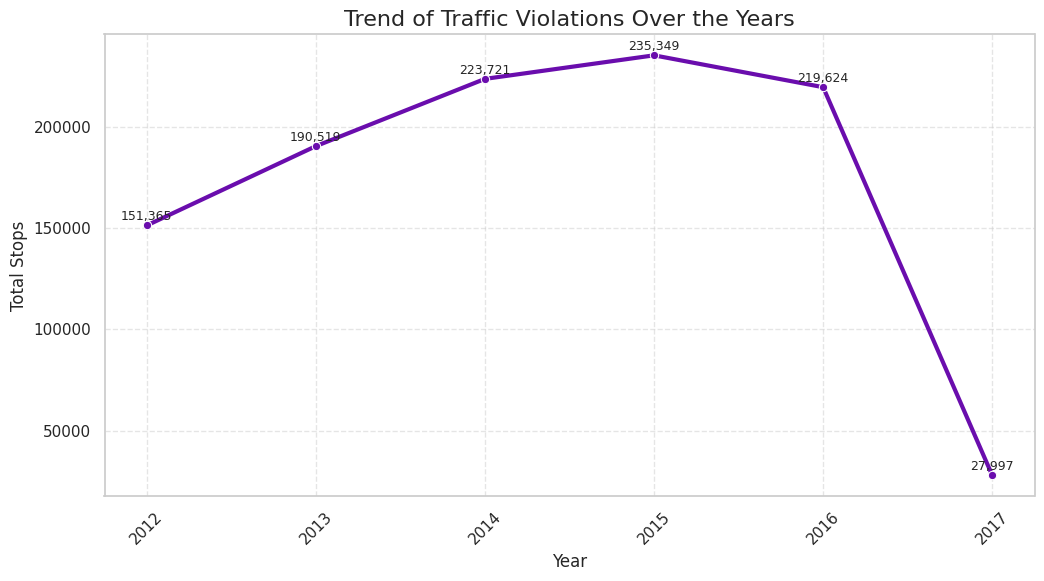

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. טעינת נתונים - רק עמודת התאריך
file_path = '/content/drive/My Drive/my_data/traffic_violations.csv'
df = pd.read_csv(file_path, usecols=['date_of_stop'])

# 2. המרת תאריכים ושליפת השנה
df['date_of_stop'] = pd.to_datetime(df['date_of_stop'], format='%m/%d/%Y', errors='coerce')
df['year'] = df['date_of_stop'].dt.year

# הסרת שנים לא תקינות (אם יש)
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

# 3. ספירת דוחות לפי שנה
yearly_counts = df['year'].value_counts().sort_index().reset_index()
yearly_counts.columns = ['year', 'count']

# סינון: לפעמים יש שנים עתיקות בטעות או שנים חלקיות מאוד בהתחלה/סוף
# נציג את הנתונים משנת 2012 ואילך (בדרך כלל הדאטה הזה מתחיל שם)
yearly_counts = yearly_counts[yearly_counts['year'] >= 2012]

print("=== Traffic Stops per Year ===")
print(yearly_counts)

# 4. ויזואליזציה (גרף מגמה)
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_counts, x='year', y='count', marker='o', linewidth=3, color='#6a0dad') # סגול

# עיצוב הגרף
plt.title('Trend of Traffic Violations Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Stops', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# הוספת תוויות מספריות על הנקודות
for x, y in zip(yearly_counts['year'], yearly_counts['count']):
    plt.text(x, y + 1000, f'{y:,}', ha='center', va='bottom', fontsize=9)

plt.xticks(yearly_counts['year'].unique(), rotation=45)
plt.show()


In [12]:
import pandas as pd

file_path = '/content/drive/My Drive/my_data/traffic_violations.csv'

# קריאה של השורה הראשונה בלבד כדי לראות כותרות
df_temp = pd.read_csv(file_path, nrows=0)

print("=== רשימת העמודות בקובץ ===")
for col in df_temp.columns:
    print(col)

=== רשימת העמודות בקובץ ===
date_of_stop
time_of_stop
agency
subagency
description
location
latitude
longitude
accident
belts
personal_injury
property_damage
fatal
commercial_license
hazmat
commercial_vehicle
alcohol
work_zone
state
vehicletype
year
make
model
color
violation_type
charge
article
contributed_to_accident
race
gender
driver_city
driver_state
dl_state
arrest_type
geolocation


=== Top 10 Car Makes with Highest Alcohol Violation Rate ===
            make  total_stops  alcohol_rate
3024  VOLKSWAGON         4650      1.741935
2657      SUZUKI         2172      0.690608
1379      JAGUAR         1372      0.655977
477        CHEVY        24646      0.592388
1908        MINI         2093      0.573340
2325     PONTIAC         5004      0.559552
696        DODGE        28171      0.447268
2450        SAAB         1804      0.388027
1210     HYUNDAI        18142      0.374821
264        BUICK         5975      0.368201


/tmp/ipython-input-3460285089.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_drunkest_cars, x='alcohol_rate', y='make', palette='Reds_r')


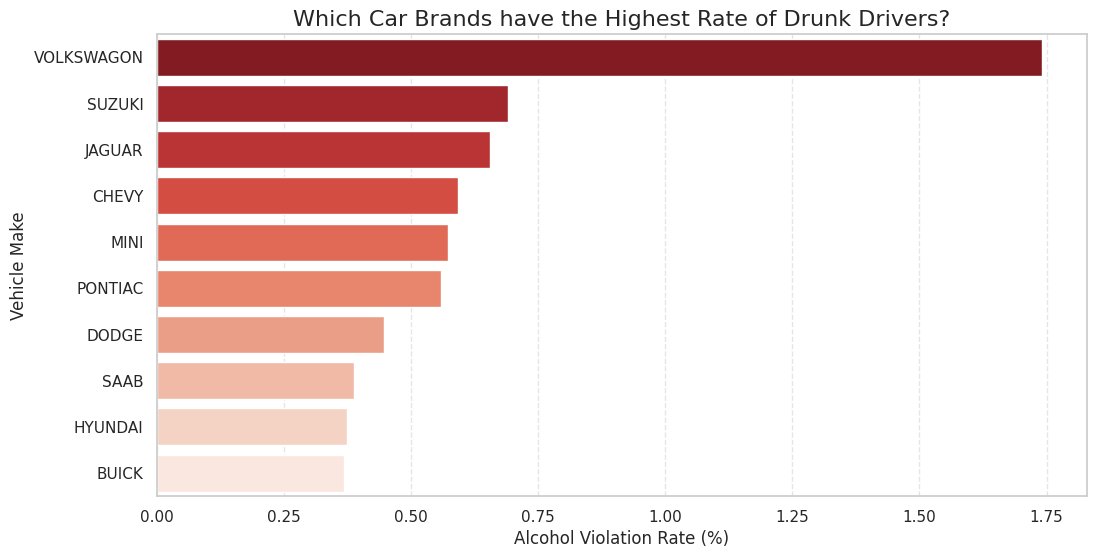

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
# We only need the 'make' (Car Manufacturer) and 'alcohol' (Violation flag) columns
file_path = '/content/drive/My Drive/my_data/traffic_violations.csv'
df = pd.read_csv(file_path, usecols=['make', 'alcohol'])

# ---------------------------------------------------------
# 2. Data Cleaning
# ---------------------------------------------------------

# Handle missing values: Assume False (No alcohol) if the field is empty
df['alcohol'] = df['alcohol'].fillna(False).astype(bool)

# Standardize car make names:
# Convert to uppercase and strip whitespace to merge 'Toyota ' and 'TOYOTA'
df['make'] = df['make'].str.upper().str.strip()

# ---------------------------------------------------------
# 3. Analysis: Calculate DUI Rate per Make
# ---------------------------------------------------------

# Group by car make and calculate total stops and total alcohol violations
vehicle_stats = df.groupby('make').agg(
    total_stops=('alcohol', 'count'),
    alcohol_cases=('alcohol', 'sum')
).reset_index()

# Calculate the percentage of stops that involved alcohol
vehicle_stats['alcohol_rate'] = (vehicle_stats['alcohol_cases'] / vehicle_stats['total_stops']) * 100

# ---------------------------------------------------------
# 4. Statistical Filtering
# ---------------------------------------------------------

# Filter out rare cars to avoid statistical noise (e.g., a Ferrari stopped once with alcohol = 100% rate).
# We keep only makes with at least 1,000 stops to ensure the sample size is significant.
df_filtered = vehicle_stats[vehicle_stats['total_stops'] > 1000].sort_values(by='alcohol_rate', ascending=False)

# Select the top 10 makes with the highest alcohol violation rate
top_drunkest_cars = df_filtered.head(10)

# Display the results
print("=== Top 10 Car Makes with Highest Alcohol Violation Rate ===")
print(top_drunkest_cars[['make', 'total_stops', 'alcohol_rate']])

# ---------------------------------------------------------
# 5. Visualization
# ---------------------------------------------------------

plt.figure(figsize=(12, 6))
sns.barplot(data=top_drunkest_cars, x='alcohol_rate', y='make', palette='Reds_r')

# Add titles and labels
plt.title('Which Car Brands have the Highest Rate of Drunk Drivers?', fontsize=16)
plt.xlabel('Alcohol Violation Rate (%)', fontsize=12)
plt.ylabel('Vehicle Make', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

=== CORRECTED Top 10 Car Makes (Cleaned Data) ===
            make  total_stops  alcohol_rate
3017  VOLKSWAGEN         7307      1.108526
2656      SUZUKI         2172      0.690608
1378      JAGUAR         1372      0.655977
1907        MINI         2093      0.573340
2324     PONTIAC         5004      0.559552
695        DODGE        28171      0.447268
476        CHEVY        47164      0.438894
2449        SAAB         1804      0.388027
1209     HYUNDAI        18142      0.374821
264        BUICK         5975      0.368201


/tmp/ipython-input-3552662614.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_drunkest_cars, x='alcohol_rate', y='make', palette='Oranges_r')


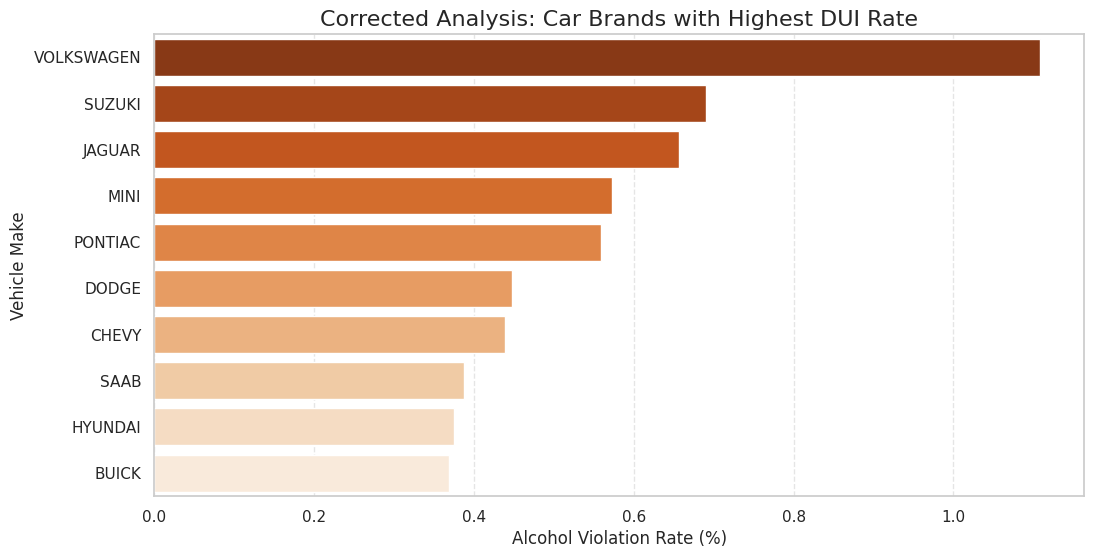

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
file_path = '/content/drive/My Drive/my_data/traffic_violations.csv'
df = pd.read_csv(file_path, usecols=['make', 'alcohol'])

# ---------------------------------------------------------
# 2. Advanced Data Cleaning (The Final Polish)
# ---------------------------------------------------------

# Basic cleaning
df['alcohol'] = df['alcohol'].fillna(False).astype(bool)
df['make'] = df['make'].str.upper().str.strip()

# FIX TYPOS: Merging "VOLKSWAGON" into "VOLKSWAGEN"
# We can also fix other common ones if they exist
typo_mapping = {
    'VOLKSWAGON': 'VOLKSWAGEN',
    'TOYOTA MOTOR CORP': 'TOYOTA',
    'FORD MOTOR CO': 'FORD',
    'CHEVROLET': 'CHEVY' # Unifying Chevy/Chevrolet
}

df['make'] = df['make'].replace(typo_mapping)

# ---------------------------------------------------------
# 3. Re-Analyze DUI Rate
# ---------------------------------------------------------

vehicle_stats = df.groupby('make').agg(
    total_stops=('alcohol', 'count'),
    alcohol_cases=('alcohol', 'sum')
).reset_index()

vehicle_stats['alcohol_rate'] = (vehicle_stats['alcohol_cases'] / vehicle_stats['total_stops']) * 100

# ---------------------------------------------------------
# 4. Filter & Sort
# ---------------------------------------------------------

# Filter for significant sample size (> 1000 stops)
df_filtered = vehicle_stats[vehicle_stats['total_stops'] > 1000].sort_values(by='alcohol_rate', ascending=False)

top_drunkest_cars = df_filtered.head(10)

print("=== CORRECTED Top 10 Car Makes (Cleaned Data) ===")
print(top_drunkest_cars[['make', 'total_stops', 'alcohol_rate']])

# ---------------------------------------------------------
# 5. Final Visualization
# ---------------------------------------------------------

plt.figure(figsize=(12, 6))
sns.barplot(data=top_drunkest_cars, x='alcohol_rate', y='make', palette='Oranges_r')

plt.title('Corrected Analysis: Car Brands with Highest DUI Rate', fontsize=16)
plt.xlabel('Alcohol Violation Rate (%)', fontsize=12)
plt.ylabel('Vehicle Make', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()